In [1]:
import sys
sys.path.append('/global/homes/m/mehdi/github/DESILSS')
from nnbar import NNBAR, hpixsum

In [2]:
import healpy as hp
import numpy as np
import fitsio as ft

In [3]:
import matplotlib.pyplot as plt

Step 1: read galaxy and random catalogs

In [4]:
!echo $SCRATCH
!ls /global/cscratch1/sd/mehdi/dr5_anand/desi

/global/cscratch1/sd/mehdi
DESI.ELG.dr5.fits	   Masks     dr5aidebv.npy  ngal-features.fits
DESI.ELG.dr5.mskinfo.fits  dr54fold  dr5debv.npy


In [5]:
# read galaxy and randoms
data = ft.read('/global/cscratch1/sd/mehdi/dr5_anand/desi/ngal-features.fits', lower=True)

In [25]:
ranmap = np.zeros(12*256**2)
elgmap = np.zeros(12*256**2)
ranmap[data['hpix']] = data['features'][:,2]
mask   = ranmap > 0.2
elgmap[data['hpix']] = data['label'] * data['features'][:,2] # label = Ngal/Fracgood
ebv    = np.zeros(12*256**2)
ebv[data['hpix']]    = data['features'][:,0]

Step 2: make healpix maps of galaxy and random

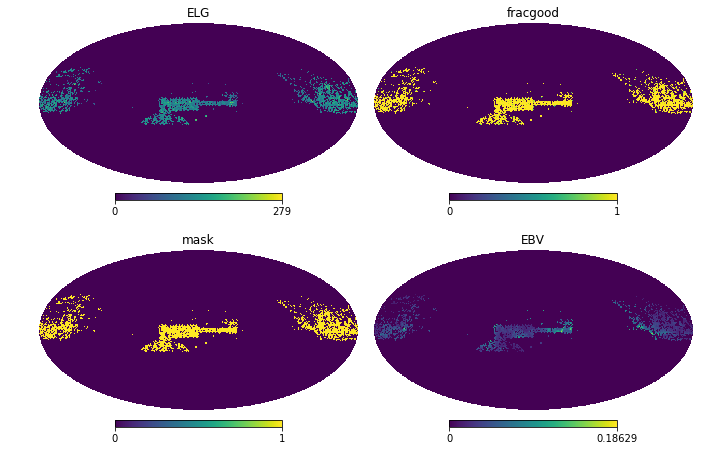

In [27]:
plt.figure(figsize=(12, 16))
plt.subplots_adjust(wspace=0.0, hspace=0.2)
kw = dict(hold=True)
plt.subplot(421)
hp.mollview(elgmap, title='ELG', **kw)
plt.subplot(422)
hp.mollview(ranmap, title='fracgood', **kw)
plt.subplot(423)
hp.mollview(mask, title='mask', **kw)
plt.subplot(424)
hp.mollview(ebv, title='EBV', **kw)

In [52]:
from glob import glob

In [54]:
path3 = '/global/cscratch1/sd/mehdi/dr5_anand/'
files = glob('/global/cscratch1/sd/mehdi/dr5_anand/desi/dr54fold/fold*/*')
files.sort()
files

['/global/cscratch1/sd/mehdi/dr5_anand/desi/dr54fold/fold0/reg-nepoch500-nchain10-batchsize2000units1010-Lrate0.01.npz',
 '/global/cscratch1/sd/mehdi/dr5_anand/desi/dr54fold/fold1/reg-nepoch500-nchain10-batchsize2000units1010-Lrate0.01.npz',
 '/global/cscratch1/sd/mehdi/dr5_anand/desi/dr54fold/fold2/reg-nepoch500-nchain10-batchsize2000units1010-Lrate0.01.npz',
 '/global/cscratch1/sd/mehdi/dr5_anand/desi/dr54fold/fold3/reg-nepoch500-nchain10-batchsize2000units1010-Lrate0.01.npz']

In [35]:
mock = NNBAR(elgmap, ranmap, mask, ebv, np.logspace(np.log10(0.002), np.log10(0.2), 21))

In [36]:
mock.run(njack=30)

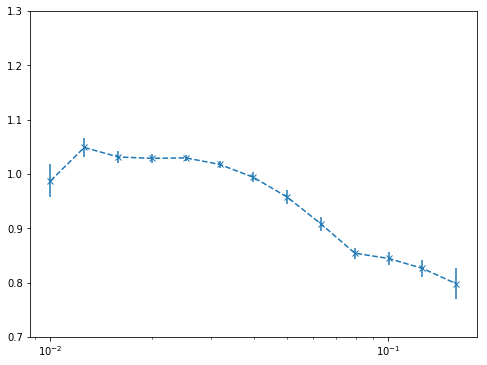

In [51]:
def plot_nnbar(output, **kw):
    # x, y, ye
    x = (output['bin_edges'][:-1],
         output['nnbar'],
         output['nnbar_err'])
    plt.errorbar(*x, **kw) #x,y,ye
    
plt.figure(figsize=(8,6))
plt.xscale('log')
plt.ylim([0.7,1.3])
plot_nnbar(mock.output, marker='x', ls='--')

In [55]:
def read_NNfolds(files):
    """
    Reading the Ngal and systematic
    """
    p_true = []
    x_true = []
    y_true = []
    y_pred = []
    #y_base = []
    for j,file_i in enumerate(files):
        d = np.load(file_i)
        out = d['arr_0'].item()
        p_true.append(out['test'][0])
        x_true.append(out['test'][1])
        y_true.append(out['test'][2].squeeze())
        #ybasei = np.ones(out['test'][2].shape[0])*np.mean(out['train'][2])
        #print(np.sqrt(np.mean((out['test'][2].squeeze() - ybasei)**2)), ybasei[0])
        #y_base.append(ybasei)
        y_avg = []
        for i in range(len(out['chain_y'])):
            y_avg.append(out['chain_y'][i][1].squeeze().tolist())    
        meanY, stdY = out['options']['stats']['ystat']
        #print(meanY, stdY)
        y_pred.append(stdY*np.mean(np.array(y_avg), axis=0) + meanY)

    Ptrue = np.concatenate(p_true)
    Xtrue = np.concatenate(x_true)
    Ytrue = np.concatenate(y_true)
    #Ybase = np.concatenate(y_base)
    Ypred = np.concatenate(y_pred)
    nnmap = np.zeros(12*256**2)
    nnmap[Ptrue] = Ypred
    return nnmap

In [56]:
nnmap = read_NNfolds(files)

In [58]:
AImock = NNBAR(elgmap, ranmap, mask, ebv, 
             np.logspace(np.log10(0.002), np.log10(0.2), 21),
            selection=nnmap)
AImock.run(njack=30)

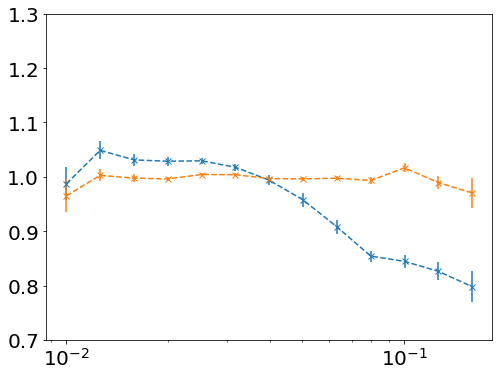

In [61]:
def plot_nnbar(output1, output2, **kw):
    # x, y, ye
    x1 = (output1['bin_edges'][:-1],
         output1['nnbar'],
         output1['nnbar_err'])
    x2 = (output2['bin_edges'][:-1],
     output2['nnbar'],
     output2['nnbar_err'])
    plt.errorbar(*x1, **kw) #x,y,ye
    plt.errorbar(*x2, **kw)

plt.rc('font', size=20)
plt.figure(figsize=(8,6))
plt.xscale('log')

plt.ylim([0.7,1.3])
plot_nnbar(mock.output, AImock.output, marker='x', ls='--')